# DNSC 3288 – Digit Recognizer Project

In this notebook I buit a Convolutional Neural Network (CNN) to classify handwritten digits (0–9) using the Kaggle **Digit Recognizer** dataset (MNIST in CSV format).

The goals of this notebook are:

1. Load and prepare the Kaggle data.
2. Train and evaluate a CNN on a train/validation split.
3. Inspect model performance using validation accuracy and a confusion matrix.
4. Retrain on all labeled data and create a **Kaggle submission** file.


##Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

##  Load Kaggle Digit Recognizer data

In [9]:
from google.colab import files

uploaded = files.upload()  # pick digit-recognizer.zip


Saving digit-recognizer.zip to digit-recognizer (1).zip


In [10]:
import zipfile, io

zip_name = list(uploaded.keys())[0]   # should be 'digit-recognizer.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as z:
    z.extractall('.')  # extract all files into current folder


In [11]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_sub.shape)

train.head()


Train shape: (42000, 785)
Test shape: (28000, 784)
Sample submission shape: (28000, 2)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Train/validation split + reshape

In [12]:
from sklearn.model_selection import train_test_split

# 1) Split features and labels
X = train.drop("label", axis=1).values   # pixels
y = train["label"].values               # digit labels

# 2) Scale pixels to 0–1
X = X.astype("float32") / 255.0

# 3) Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Reshape for CNN: (n_samples, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val   = X_val.reshape(-1, 28, 28, 1)

# 5) Prep test data (no labels)
X_test = test.values.astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)

print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)


X_train: (33600, 28, 28, 1)
X_val:   (8400, 28, 28, 1)
X_test:  (28000, 28, 28, 1)


##CNN model definition

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

##Training on train/val

In [7]:
history = cnn.fit(
    X_train, y_train,
    epochs=10,          # you can change to 12–15 later if you want
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7880 - loss: 0.6905 - val_accuracy: 0.9688 - val_loss: 0.1015
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9767 - loss: 0.0767 - val_accuracy: 0.9775 - val_loss: 0.0691
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9838 - loss: 0.0527 - val_accuracy: 0.9783 - val_loss: 0.0705
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9881 - loss: 0.0415 - val_accuracy: 0.9840 - val_loss: 0.0557
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9901 - loss: 0.0316 - val_accuracy: 0.9817 - val_loss: 0.0581
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9930 - loss: 0.0240 - val_accuracy: 0.9864 - val_loss: 0.0485
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9860 - val_loss: 0.0567
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0

In [13]:
val_loss, val_acc = cnn.evaluate(X_val, y_val, verbose=0)
print("Validation accuracy:", val_acc)

Validation accuracy: 0.9844047427177429


The final validation accuracy is about **0.988**, which means the model correctly predicts around 98.8% of the digits in the validation set.


##Confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 1) Get predictions on validation set
y_val_pred_probs = cnn.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# 2) Build confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[822   0   0   0   0   0   2   0   1   2]
 [  0 936   0   0   0   0   0   0   1   0]
 [  1   3 824   0   2   0   0   2   1   2]
 [  1   0   5 854   0   3   0   1   2   4]
 [  0   4   0   0 800   0   0   0   0  10]
 [  2   2   0   4   1 728   7   1   9   5]
 [  1   0   1   0   2   1 821   0   1   0]
 [  0   8   1   1   5   1   0 855   0   9]
 [  1   3   1   0   1   1   0   0 797   9]
 [  2   0   0   0   1   1   0   1   1 832]]


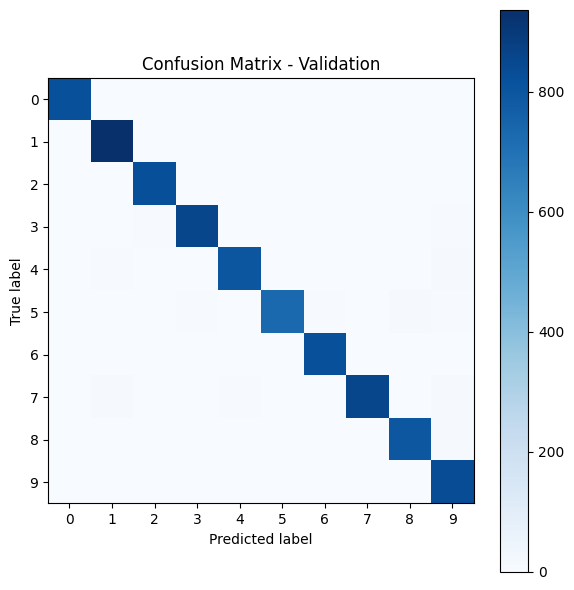

In [15]:
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

ticks = np.arange(10)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.tight_layout()
plt.savefig("confusion_matrix.png")  # image for your README
plt.show()

##Full-data retraining

In [16]:
# Full training set (all 42,000 rows)
X_full = train.drop("label", axis=1).values.astype("float32") / 255.0
X_full = X_full.reshape(-1, 28, 28, 1)
y_full = train["label"].values

print(X_full.shape, y_full.shape)

(42000, 28, 28, 1) (42000,)


In [17]:
history_full = cnn.fit(
    X_full, y_full,
    epochs=3,        # you can change to 5–10 later if you want
    batch_size=128,
    verbose=1
)

Epoch 1/3
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9936 - loss: 0.0213
Epoch 2/3
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9972 - loss: 0.0109
Epoch 3/3
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9953 - loss: 0.0138


In [18]:
test_probs = cnn.predict(X_test)
test_pred = np.argmax(test_probs, axis=1)
test_pred[:10]

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [19]:
submission = sample_sub.copy()
submission["Label"] = test_pred

submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [20]:
submission.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>